In [3]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
functions_dir = os.path.join(Path.home(), 'ecc-cracks')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

import functions
from tutorials.unet_model import construct_unet

In [2]:
# https://stackoverflow.com/questions/61909973/pytorch-load-incompatiblekeys

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = construct_unet(5)
unet = DataParallel(unet)
retrained_weight_path = '/projects/wg-psel-ml/EL_images/eccoope/checkpoints/dm_checkpoints7/epoch_30/model.pt'

checkpoint = torch.load(retrained_weight_path)
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = "module." + k
    new_state_dict[name] = v

unet.load_state_dict(new_state_dict)
retrained_model = unet.module.to(device)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = construct_unet(5)
unet = DataParallel(unet)
old_weight_path = '/home/eccoope/ecc-cracks/unet_oversample_low_final_model_for_paper/model.pt'

unet.load_state_dict(torch.load(old_weight_path))
old_model = unet.module.to(device)

In [6]:
root = Path('/projects/wg-psel-ml/EL_images/eccoope')
transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])

trainset = functions.SolarDataset(root, image_folder="img/train", 
        mask_folder="ann/train", transforms=transformers)

valset = functions.SolarDataset(root, image_folder="img/val", 
        mask_folder="ann/val", transforms=transformers)

batch_size_val=1
batch_size_train=1

train_loader = DataLoader(trainset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size_val, shuffle=False)

In [10]:
# train_loader.dataset.mask_list

In [12]:
ann_dir = '/projects/wg-psel-ml/EL_images/eccoope/ann/val'

In [12]:
[c for c in val_loader.dataset.mask_list if '2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71' in c]

['/projects/wg-psel-ml/EL_images/eccoope/ann/val/bu_2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71.npy',
 '/projects/wg-psel-ml/EL_images/eccoope/ann/val/cr_2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71.npy']

In [14]:
mask_cpu.shape

torch.Size([256, 256])

In [15]:
retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze().shape

(5, 256, 256)

/home/eccoope/dmenv/lib64/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


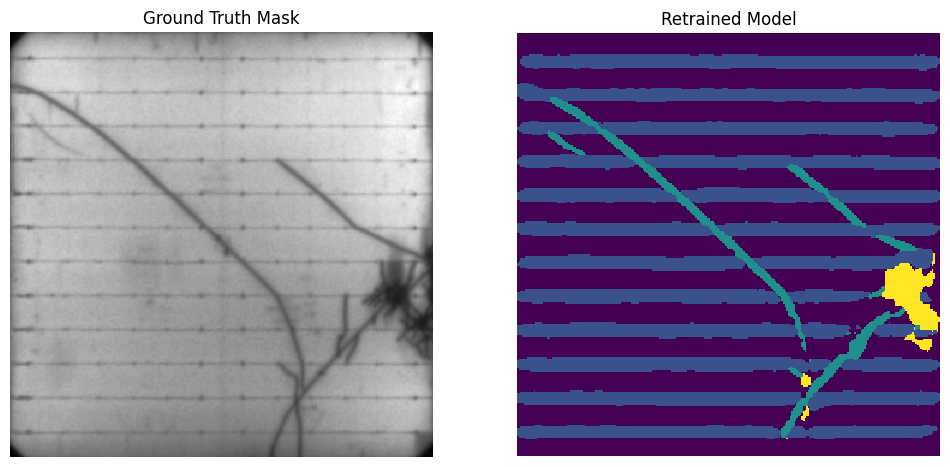

In [13]:
cr_name = 'cr_2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71.npy'
cr_idx = np.ravel(np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name)))[0]
bu_name = 'bu_2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71.npy'
bu_idx = np.ravel(np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name)))[0]

img, mask = val_loader.dataset. __getitem__(cr_idx)
img = img.to(device)
retrained_test_res = np.argmax(retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze(), axis = 0)

mask_cpu = mask.cpu()

raw_img, _ = val_loader.dataset. __getraw__(cr_idx)


my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4 : 'dark'}


fig, ax = plt.subplots(ncols=2, figsize=(12,6))
clim = (0, 4)
im = ax[0].imshow(raw_img.convert('L'), cmap='gray', interpolation='None')
ax[0].axis('off')
ax[0].set_title("Ground Truth Mask")

cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]

ax[1].imshow(retrained_test_res, cmap =cmap, clim = clim, interpolation='None')

handles, labels = ax[1].get_legend_handles_labels()

for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in my_map.items()]):
        patch = mpatches.Patch(color=c, label=classlabel, ec='k')
        handles.append(patch)
# ax[1].legend(handles=handles, fontsize='x-small')

ax[1].set_title("Retrained Model")
ax[1].axis('off');

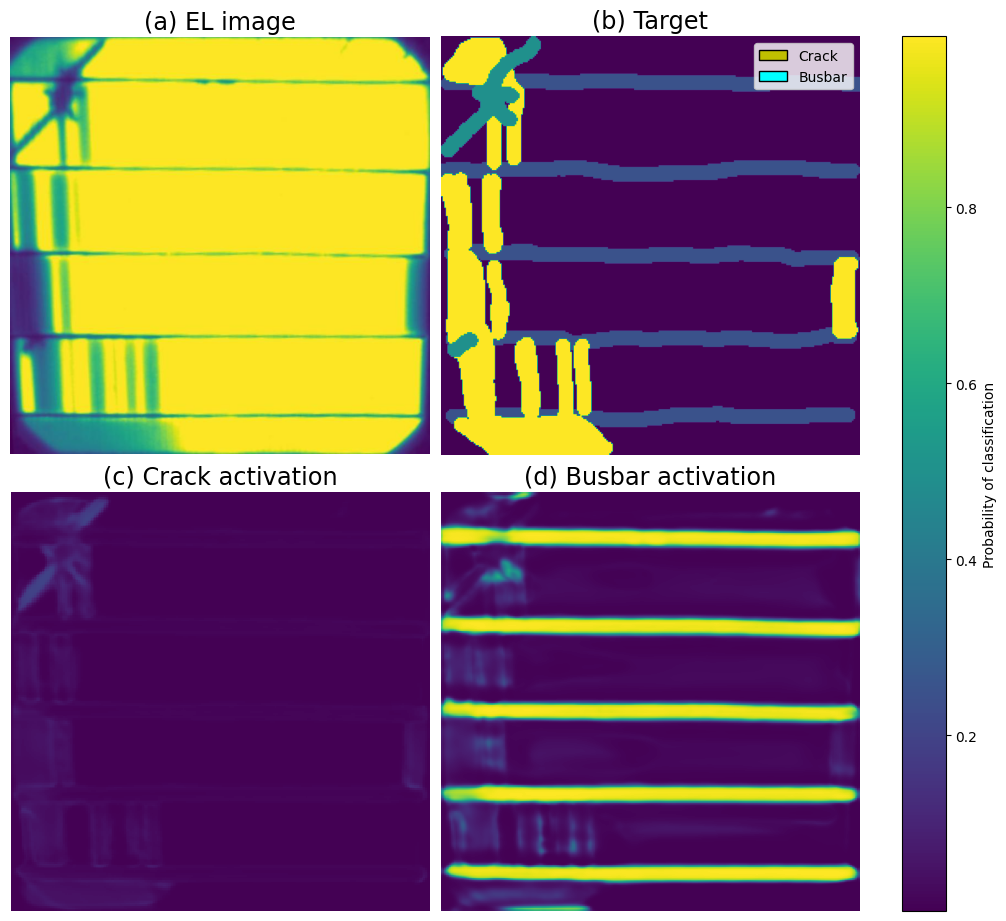

In [9]:
img, cr_mask = train_loader.dataset. __getitem__(cr_idx)
cr_mask = functions.realign_mask(cr_mask)
img, bu_mask = train_loader.dataset. __getitem__(bu_idx)
bu_mask = functions.realign_mask(bu_mask)
img = img.to(device)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

cr_layer = test_res_act[2]
bu_layer = test_res_act[1]

cr_act = cr_layer[(bu_mask.numpy() == 1) & (cr_mask.numpy() == 2)]
bu_act = bu_layer[(bu_mask.numpy() == 1) & (cr_mask.numpy() == 2)]
    
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), layout='compressed')

img, _ = train_loader.dataset.__getraw__(bu_idx)
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('(a) EL image', fontsize='xx-large')

ax[0, 1].imshow(cr_mask, cmap='viridis')
ax[0, 1].axis('off')
ax[0, 1].set_title('(b) Target', fontsize='xx-large')
handles, labels = ax[0, 1].get_legend_handles_labels()
yellow_patch = mpatches.Patch(color='y', label='Crack', ec='k')
handles.append(yellow_patch)
cyan_patch = mpatches.Patch(color='cyan', label='Busbar', ec='k')
handles.append(cyan_patch)
ax[0, 1].legend(handles=handles)

ax[1, 0].imshow(cr_layer, cmap='viridis', clim=clim, interpolation='None')
ax[1, 0].axis('off')
ax[1, 0].set_title('(c) Crack activation', fontsize='xx-large')
im = ax[1, 1].imshow(bu_layer, cmap='viridis')
ax[1, 1].axis('off')
ax[1, 1].set_title('(d) Busbar activation', fontsize='xx-large')
fig.colorbar(im, ax=ax, label='Probability of classification');

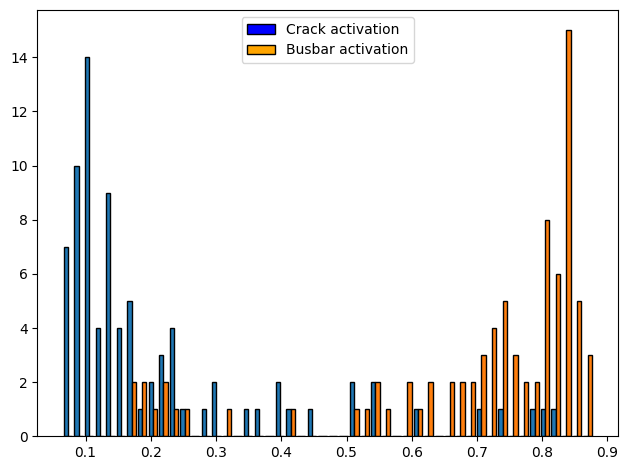

In [20]:
fig, ax = plt.subplots()

ax.hist([cr_act,  bu_act], bins=50, ec='k')

handles, labels = ax.get_legend_handles_labels()
o_patch = mpatches.Patch(color='orange', label='Busbar activation', ec='k')
b_patch = mpatches.Patch(color='b', label='Crack activation', ec='k')
handles.append(b_patch) 
handles.append(o_patch) 
ax.legend(handles=handles)
fig.tight_layout();

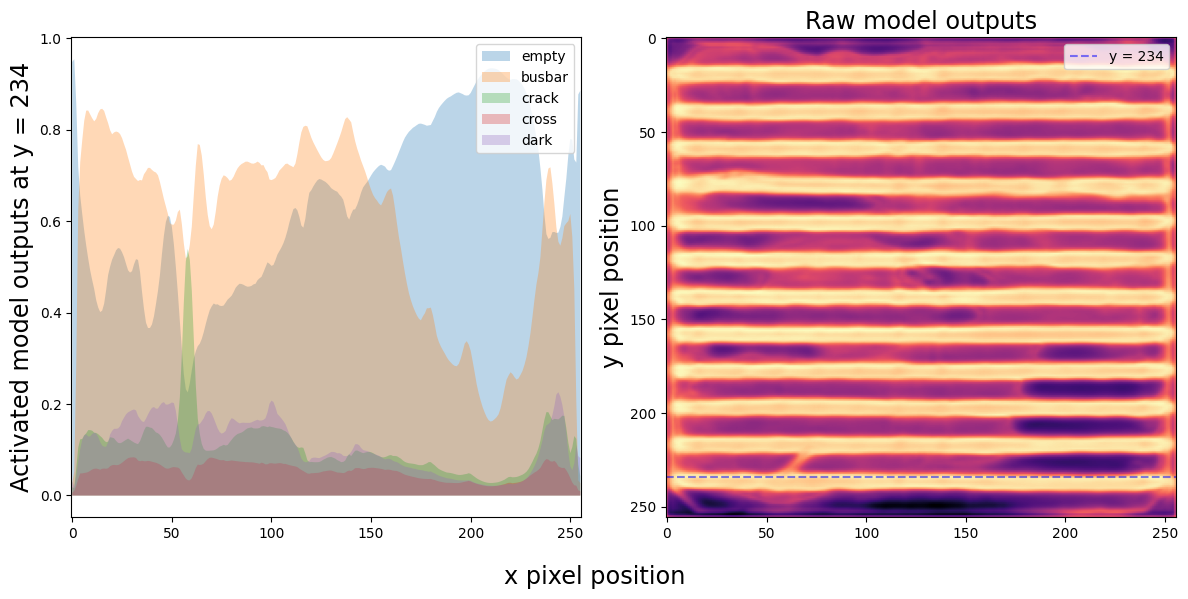

In [8]:
my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4: 'dark'}

# idx = train_idx[0]
img, mask = train_loader.dataset. __getitem__(cr_idx)
img = img.to(device)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
test_res = np.argmax(test_res, axis = 0)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

yslice= 234
xmax = 60
ymax = 256

sliced = test_res_act[:, yslice, :]
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

for i in range(sliced.shape[0]):
    ax[0].fill_between(np.arange(0, 256, 1), sliced[i], alpha=0.3, label=my_map[i])
ax[0].legend()
ax[0].set_ylabel(f'Activated model outputs at y = {yslice}', fontsize='xx-large')

ax[1].imshow(test_res_chan.sum(axis = 0), cmap  = "magma")
ax[1].set_aspect('auto')
ax[1].axhline(yslice, ls='--', c='b', alpha=0.5, label=f'y = {yslice}')
ax[1].legend()
ax[1].set_title('Raw model outputs', fontsize='xx-large')
ax[1].set_ylabel('y pixel position', fontsize='xx-large')
fig.supxlabel('x pixel position', fontsize='xx-large')
# fig.suptitle(val_loader.dataset. __getname__(cr_idx))
fig.tight_layout();

Text(0.5, 1.0, 'Activated model outputs at y = 234')

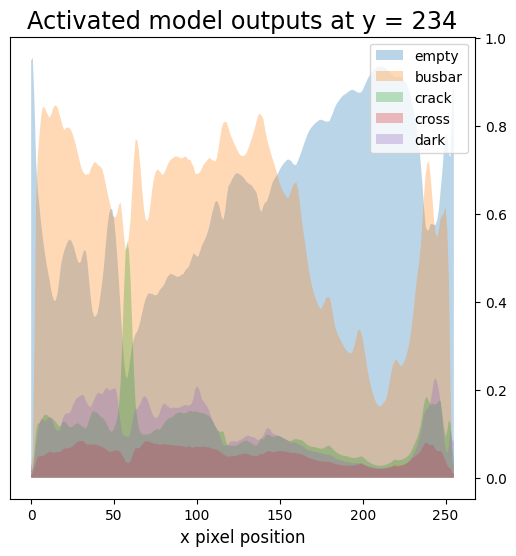

In [24]:
my_map = {0 : 'empty',
          1 : 'busbar',
          2 : 'crack',
          3 : 'cross',
          4: 'dark'}

# idx = train_idx[0]
img, mask = train_loader.dataset. __getitem__(cr_idx)
img = img.to(device)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
test_res = np.argmax(test_res, axis = 0)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

yslice= 234
xmax = 60
ymax = 256

sliced = test_res_act[:, yslice, :]
fig, ax = plt.subplots(figsize=(6,6))

for i in range(sliced.shape[0]):
    ax.fill_between(np.arange(0, 256, 1), sliced[i], alpha=0.3, label=my_map[i])
ax.legend()
ax.yaxis.tick_right()
ax.set_xlabel('x pixel position', fontsize='large')
ax.set_title(f'Activated model outputs at y = {yslice}', fontsize='xx-large')

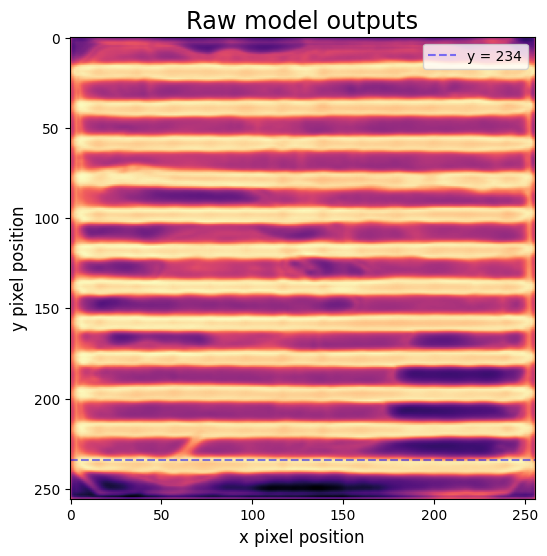

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(test_res_chan.sum(axis = 0), cmap  = "magma")
ax.axhline(yslice, ls='--', c='b', alpha=0.5, label=f'y = {yslice}')
ax.legend()
ax.set_title('Raw model outputs', fontsize='xx-large')
ax.set_ylabel('y pixel position', fontsize='large')
ax.set_xlabel('x pixel position', fontsize='large')
ax.set_aspect('auto')